In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/ubuntu/fastai/')
from fastai.imports import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [4]:
PATH = Path('/home/ubuntu/data/dl2/pascal/')
list(PATH.iterdir())

[PosixPath('/home/ubuntu/data/dl2/pascal/tmp'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('/home/ubuntu/data/dl2/pascal/pascal_train2012.json'),
 PosixPath('/home/ubuntu/data/dl2/pascal/pascal_val2012.json'),
 PosixPath('/home/ubuntu/data/dl2/pascal/models'),
 PosixPath('/home/ubuntu/data/dl2/pascal/pascal_val2007.json'),
 PosixPath('/home/ubuntu/data/dl2/pascal/pascal_train2007.json'),
 PosixPath('/home/ubuntu/data/dl2/pascal/pascal_test2007.json')]

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [7]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [8]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [9]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [10]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/Annotations')]

In [11]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [12]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('/home/ubuntu/data/dl2/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

In [13]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [14]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [15]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [16]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [17]:
cats[7]

'car'

In [18]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [19]:
cats[15], cats[13]

('person', 'horse')

In [20]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [21]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [22]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [23]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [24]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [25]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [26]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [27]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

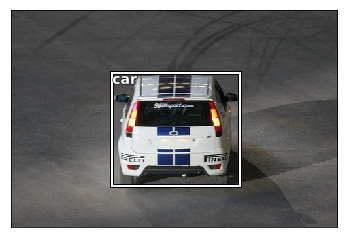

In [28]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [29]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [30]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


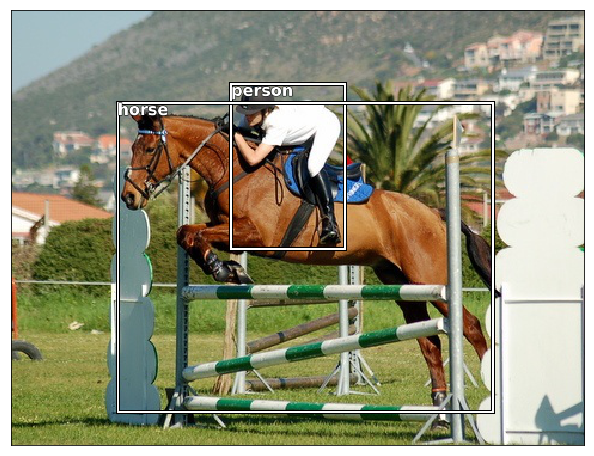

In [31]:
draw_idx(17)

In [32]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [33]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

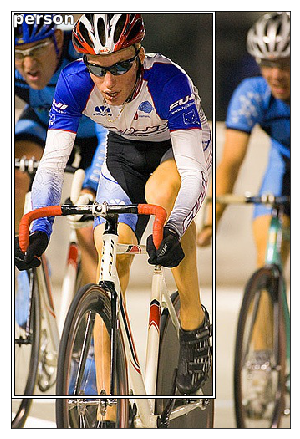

In [34]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [35]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [36]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [37]:
f_model = resnet34
sz=224
bs=64

In [38]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [39]:
x,y=next(iter(md.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


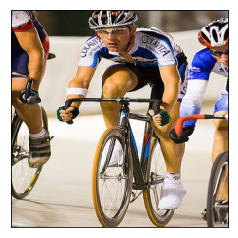

In [40]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [41]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [42]:
lrf=learn.lr_find(1e-5,100)

 78%|███████▊  | 25/32 [00:10<00:02,  2.39it/s, loss=5.09]

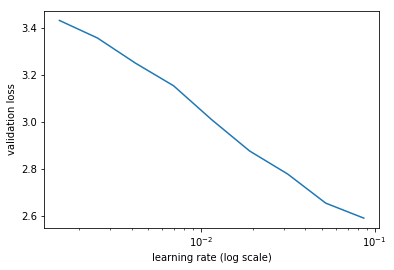

In [43]:
learn.sched.plot()

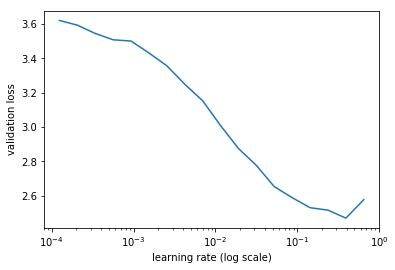

In [44]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [45]:
lr = 2e-2

In [46]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.285297   0.632102   0.808     


[0.6321023316383362, 0.8080000023841858]

In [47]:
lrs = np.array([lr/1000,lr/100,lr])

In [48]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:16<00:03,  1.59it/s, loss=2.25] 

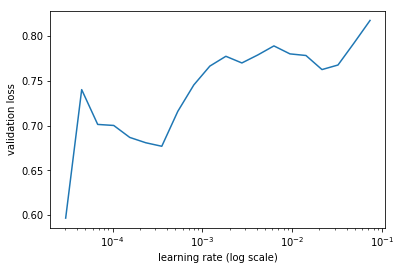

In [49]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [50]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.770539   0.572629   0.816     


[0.5726294810771942, 0.8160000023841858]

In [51]:
learn.unfreeze()

In [52]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.631637   0.587476   0.812     
    1      0.450978   0.545144   0.83                      


[0.5451436374187469, 0.8300000023841858]

In [53]:
learn.save('clas_one')

In [54]:
learn.load('clas_one')

In [55]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


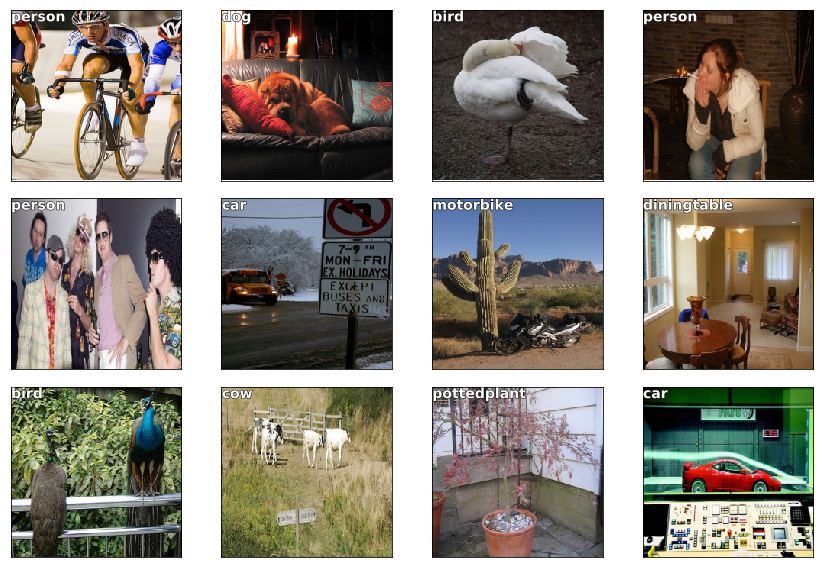

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [57]:
BB_CSV = PATH/'tmp/bb.csv'

In [58]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [59]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [60]:
f_model=resnet34
sz=224
bs=64

In [61]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [62]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


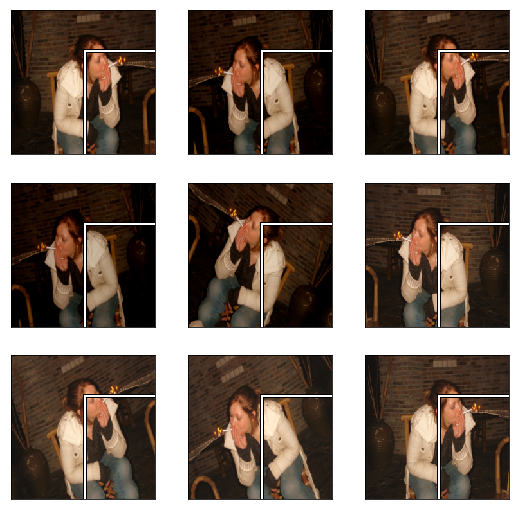

In [63]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [64]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [66]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 52.  38. 106. 183.]
[ 52.  38. 106. 183.]
[ 52.  37. 107. 186.]
[ 53.  21. 137. 202.]
[ 35.  19. 154. 204.]
[ 58.  32. 118. 191.]
[ 39.  21. 149. 202.]
[ 45.   9. 159. 214.]
[ 66.  38. 105. 183.]


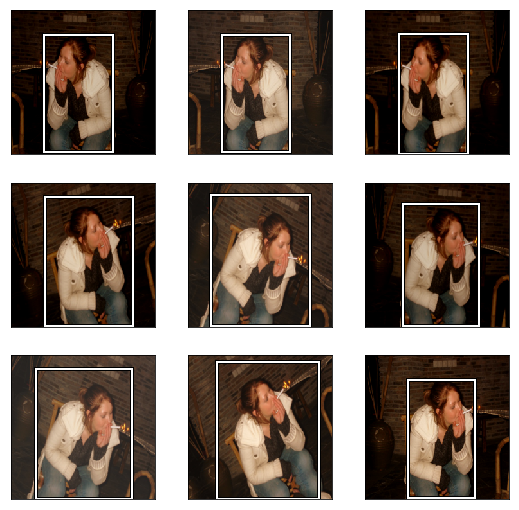

In [67]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [68]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

In [69]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

In [70]:
512*7*7

25088

In [71]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [72]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

 78%|███████▊  | 25/32 [00:13<00:03,  1.84it/s, loss=329] 

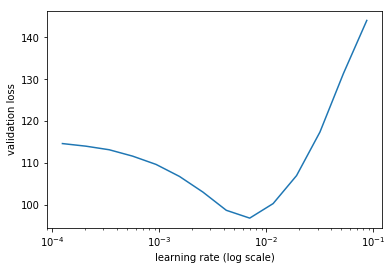

In [73]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [74]:
lr = 2e-3

In [75]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      49.918182  35.830519 
    1      37.762471  28.364573                           
    2      31.712312  28.036158                           


[28.036158401489256]

In [76]:
lrs = np.array([lr/100,lr/10,lr])

In [77]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      79.526105  339818049219592.2


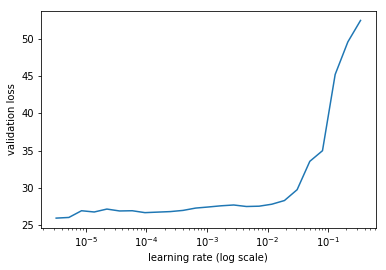

In [78]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [79]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      26.364989  22.975997 
    1      22.796054  20.45371                            
    2      19.582107  19.652197                           


[19.652197067260744]

In [80]:
learn.freeze_to(-3)

In [81]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      18.85921   21.363229 
    1      16.272447  19.515925                           


[19.515924682617186]

In [82]:
learn.save('reg4')

In [83]:
learn.load('reg4')

In [84]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


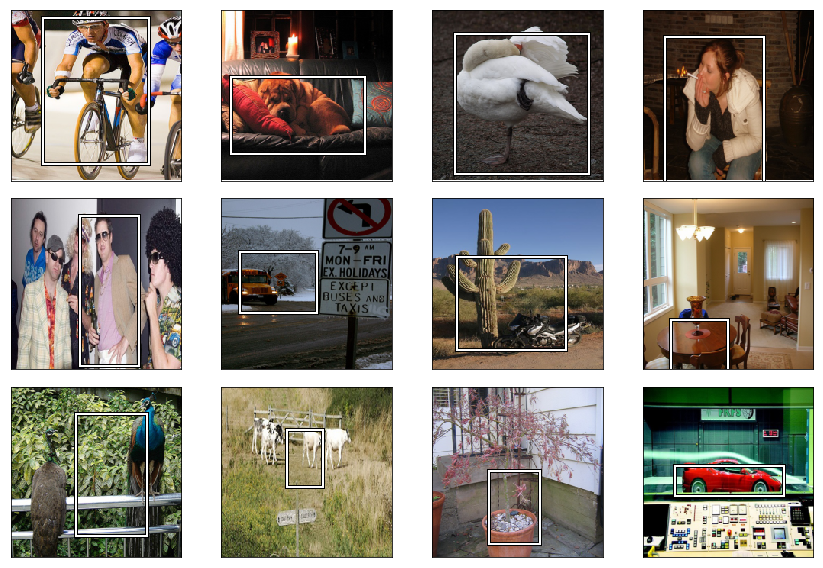

In [86]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [100]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [101]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [102]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [103]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [104]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [106]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [107]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 107., 185.])

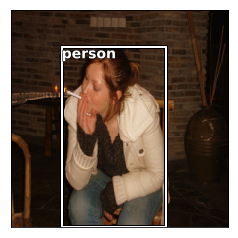

In [111]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [114]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy_np(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 94%|█████████▍| 30/32 [00:15<00:01,  1.98it/s, loss=246] 

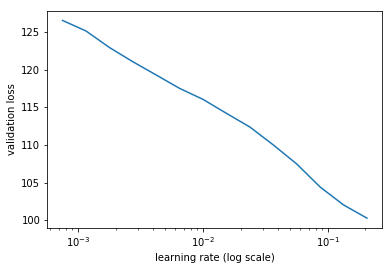

In [115]:
learn.lr_find()
learn.sched.plot()

In [116]:
lr=1e-2

In [ ]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.save('reg1_0')

In [119]:
learn.freeze_to(-2)

In [120]:
lrs = np.array([lr/100, lr/10, lr])

 91%|█████████ | 29/32 [00:18<00:01,  1.54it/s, loss=110] 

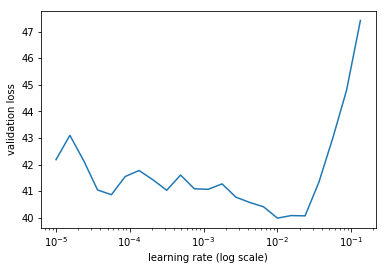

In [121]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

In [ ]:
learn.save('reg1')

In [ ]:
learn.load('reg1')

In [ ]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [ ]:
from scipy.special import expit

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()